In [1]:


def parse_cognames(file_path):
    cog_map = {}
    with open(file_path, "r") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) < 3:
                continue
            cog_id = parts[0]
            letter = parts[1]
            description = parts[2]
            cog_map[cog_id] = {
                "letter": letter,
                "description": description
            }
    return cog_map



In [2]:
cog_map = parse_cognames("cognames2003-2014.tab")

我们先从处理.out/.txt/.tab开始：


先处理out和txt，这是我们这个算法能呈现出来的核心部分，也是不会变动的部分，这部分没有使用sql是因为它并不是变动非常大的，我们先要知道有哪些组成，提取出需要的数据（你如果想加也可以，我暂时是挑选了这些）;

第一组，我们处理的是.out fichier, Utiliser des codes pour Lire des comparaisons entre les sequences，这些是蛋白对之间比对的结果。


In [3]:
from pprint import pprint

def parse_blast_output(file_path):
    blast_data = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) < 12:
                continue  # 跳过不完整行
            blast_data.append({
                "qseqid": parts[0], 
                "sseqid": parts[1],
                "pident": float(parts[2]), 
                "length": int(parts[3]),
                "mismatch": int(parts[4]),
                "gaps": int(parts[5]),
                "qstart": int(parts[6]),
                "qend": int(parts[7]),
                "sstart": int(parts[8]),
                "send": int(parts[9]),
                "evalue": float(parts[10]),
                "bitscore": float(parts[11]),
            })
    return blast_data


blast_path = "QUERY-GCA_000009985.1_ASM998v1_protein__DB-GCA_000014865.1_ASM1486v1_protein.out"
blast_results = parse_blast_output(blast_path)

print(f"共读取到 {len(blast_results)} 条 BLAST 结果")
pprint(blast_results[:5])  

共读取到 2608 条 BLAST 结果
[{'bitscore': 202.0,
  'evalue': 6.1e-62,
  'gaps': 17,
  'length': 378,
  'mismatch': 223,
  'pident': 36.508,
  'qend': 365,
  'qseqid': 'BAE48805.1',
  'qstart': 1,
  'send': 468,
  'sseqid': 'ABK46241.1',
  'sstart': 95},
 {'bitscore': 561.0,
  'evalue': 0.0,
  'gaps': 17,
  'length': 604,
  'mismatch': 298,
  'pident': 47.848,
  'qend': 621,
  'qseqid': 'BAE48806.1',
  'qstart': 18,
  'send': 593,
  'sseqid': 'ABK46240.1',
  'sstart': 7},
 {'bitscore': 256.0,
  'evalue': 6.16e-87,
  'gaps': 1,
  'length': 251,
  'mismatch': 126,
  'pident': 49.402,
  'qend': 259,
  'qseqid': 'BAE48808.1',
  'qstart': 9,
  'send': 251,
  'sseqid': 'ABK46236.1',
  'sstart': 2},
 {'bitscore': 162.0,
  'evalue': 1.76e-54,
  'gaps': 0,
  'length': 112,
  'mismatch': 36,
  'pident': 67.857,
  'qend': 112,
  'qseqid': 'BAE48817.1',
  'qstart': 1,
  'send': 112,
  'sseqid': 'ABK43513.1',
  'sstart': 1},
 {'bitscore': 162.0,
  'evalue': 2.88e-54,
  'gaps': 0,
  'length': 112,
  'mismat

In [4]:
import os

db_path = "project.db"

# 删除旧数据库（如果已存在）
if os.path.exists(db_path):
    os.remove(db_path)
    print("✅ 已删除旧数据库文件。")
else:
    print("ℹ️ 未找到旧数据库，跳过删除。")

✅ 已删除旧数据库文件。


对于第二组数据，我们想要得到细菌基因组A和B对应的蛋白，每一行代表这个菌的一个蛋白位置和功能描述，相关标记，取出来。

In [5]:
def parse_feature_table(file_path):
    protein_info = {}
    with open(file_path, "r") as f:
        for line in f:
            if line.startswith("#"):
                continue
            parts = line.strip().split("\t")
            if len(parts) < 11:
                continue
            if parts[0] == "CDS" and parts[1] == "with_protein":
                try:
                    protein_id = parts[10]  # ✅ 正确 index！
                    start = int(parts[7])
                    end = int(parts[8])
                    product = parts[13] if len(parts) > 13 else "" #功能的
                    protein_info[protein_id] = {
                        "start": start,
                        "end": end,
                        "product": product
                    }
                except Exception as e:
                    print("⚠️ 出错：", e, "→", line)
    return protein_info

In [6]:
protein_info_A = parse_feature_table("GCA_000009985.1_ASM998v1_feature_table.txt")
print(f"共读取到 {len(protein_info_A)} 个蛋白注释")
for i, (k, v) in enumerate(protein_info_A.items()):
    if i >= 5:
        break
    print(k, "→", v)

共读取到 4559 个蛋白注释
BAE48805.1 → {'start': 239, 'end': 1336, 'product': 'Predicted GTPase'}
BAE48806.1 → {'start': 1352, 'end': 3265, 'product': 'NAD/FAD-utilizing enzyme apparently involved in cell division'}
BAE48807.1 → {'start': 3320, 'end': 3937, 'product': 'Predicted S-adenosylmethionine-dependent methyltransferase involved in bacterial cell division'}
BAE48808.1 → {'start': 3918, 'end': 4715, 'product': 'ATPase involved in chromosome partitioning'}
BAE48809.1 → {'start': 5702, 'end': 6118, 'product': 'hypothetical protein'}


In [7]:
protein_info_B = parse_feature_table("GCA_000014865.1_ASM1486v1_feature_table.txt")
print(f"共读取到 {len(protein_info_B)} 个蛋白注释")
for i, (k, v) in enumerate(protein_info_B.items()):
    if i >= 5:
        break
    print(k, "→", v)

共读取到 3716 个蛋白注释
ABK42530.1 → {'start': 181, 'end': 1524, 'product': 'chromosomal replication initiator protein DnaA'}
ABK42531.1 → {'start': 1570, 'end': 2700, 'product': 'DNA polymerase III, beta subunit'}
ABK42532.1 → {'start': 2711, 'end': 3859, 'product': 'DNA replication and repair protein RecF'}
ABK42533.1 → {'start': 3859, 'end': 5223, 'product': 'ATP binding protein'}
ABK42534.1 → {'start': 5220, 'end': 5909, 'product': 'hypothetical protein'}


II- Algo(Pas obligatoire)

III- Dotplot

In [8]:
#Selecter et Construire des points
def get_dotplot_points(blast_data, protein_info_A, protein_info_B,
                       identity_thresh=30.0, evalue_thresh=1e-4): #这里是暂时的，你要写好GUI才能传进来
    points = []
    for hit in blast_data:
        if hit["pident"] >= identity_thresh and hit["evalue"] <= evalue_thresh:
            qid = hit["qseqid"]
            sid = hit["sseqid"]
            if qid in protein_info_A and sid in protein_info_B:
                x = protein_info_A[qid]["start"] #横坐标：基因组A
                y = protein_info_B[sid]["start"] #纵坐标：基因组B
                points.append((x, y))
    return points

In [9]:
import matplotlib.pyplot as plt

def draw_dotplot(points):
    if not points:
        print("Check your own standard for selection")
        return
    x_vals, y_vals = zip(*points)
    plt.figure(figsize=(8, 8))
    plt.scatter(x_vals, y_vals, s=10, alpha=0.6)
    plt.xlabel("Protein position in Genome A")
    plt.ylabel("Protein position in Genome B")
    plt.title("Dotplot of Homologous Proteins")
    plt.grid(True)
    plt.tight_layout()
    plt.show

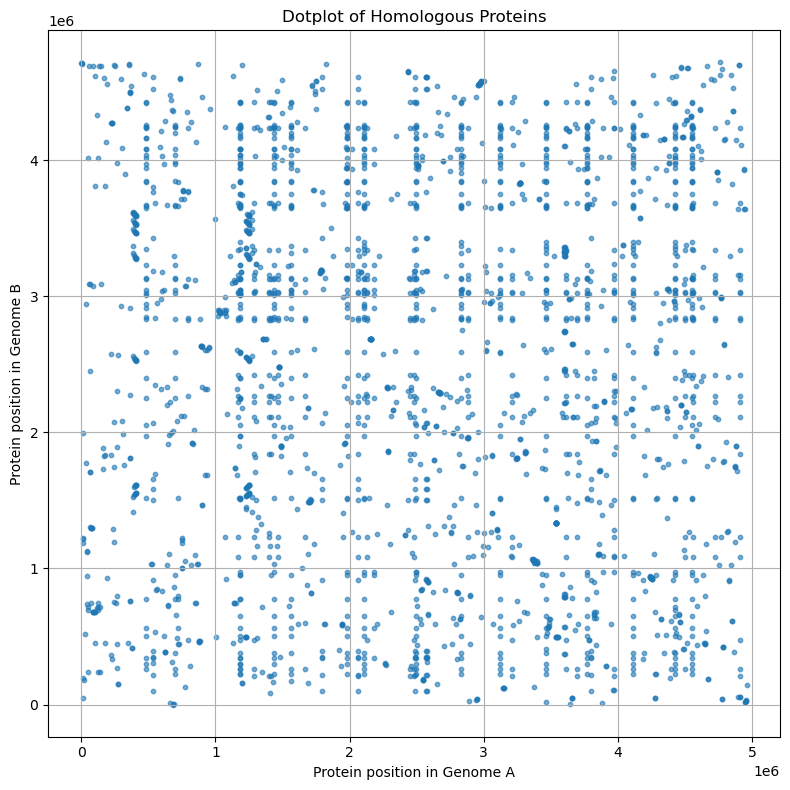

In [29]:
# 用你自己的路径先获取数据
blast_results = parse_blast_output("QUERY-GCA_000009985.1_ASM998v1_protein__DB-GCA_000014865.1_ASM1486v1_protein.out")
protein_A = parse_feature_table("GCA_000009985.1_ASM998v1_feature_table.txt")
protein_B = parse_feature_table("GCA_000014865.1_ASM1486v1_feature_table.txt")

# 获取点 + 画图
points = get_dotplot_points(blast_results, protein_A, protein_B)
draw_dotplot(points)

Patie-I: 连接sql和python： 这里是best_hits

In [8]:
import sqlite3
blast_results = parse_blast_output("QUERY-GCA_000009985.1_ASM998v1_protein__DB-GCA_000014865.1_ASM1486v1_protein.out")
conn = sqlite3.connect("project_db")
cursor = conn.cursor()

#Etablir une table blast_hits
cursor.execute("""
CREATE TABLE IF NOT EXISTS blast_hits (
    qseqid TEXT,
    sseqid TEXT,
    pident REAL,
    length INTEGER,
    mismatch INTEGER,
    gaps INTEGER,
    qstart INTEGER,
    qend INTEGER,
    sstart INTEGER,
    send INTEGER,
    evalue REAL,
    bitscore REAL,
    PRIMARY KEY (qseqid, sseqid)
);
""")

for hit in blast_results:
    cursor.execute("""
    INSERT OR IGNORE INTO blast_hits VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        hit["qseqid"], hit["sseqid"], hit["pident"], hit["length"],
        hit["mismatch"], hit["gaps"], hit["qstart"], hit["qend"],
        hit["sstart"], hit["send"], hit["evalue"], hit["bitscore"]
    ))

conn.commit()
conn.close()
print(f"✅ 成功插入 {len(blast_results)} 条数据！")

✅ 成功插入 2608 条数据！


In [9]:
def insert_blast_results_to_db(blast_results, db_path="project.db"):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    cursor.execute("""CREATE TABLE IF NOT EXISTS blast_hits (
        qseqid TEXT, sseqid TEXT, pident REAL, length INTEGER,
        mismatch INTEGER, gaps INTEGER, qstart INTEGER, qend INTEGER,
        sstart INTEGER, send INTEGER, evalue REAL, bitscore REAL,
        PRIMARY KEY (qseqid, sseqid)
    )""")

    for hit in blast_results:
        cursor.execute("""INSERT OR IGNORE INTO blast_hits VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)""", (
            hit["qseqid"], hit["sseqid"], hit["pident"], hit["length"],
            hit["mismatch"], hit["gaps"], hit["qstart"], hit["qend"],
            hit["sstart"], hit["send"], hit["evalue"], hit["bitscore"]
        ))
    
    conn.commit()
    conn.close()

blast_results = parse_blast_output("QUERY-GCA_000009985.1_ASM998v1_protein__DB-GCA_000014865.1_ASM1486v1_protein.out")
insert_blast_results_to_db(blast_results)


In [10]:
#Standards pour la selection des modele
def get_filtered_hits(cursor, identity_thresh, evalue_thresh):
    query = """
    SELECT qseqid, sseqid, qstart, sstart
    FROM blast_hits
    WHERE pident >= ? AND evalue <= ?
    """
    cursor.execute(query, (identity_thresh, evalue_thresh))
    return cursor.fetchall()

In [11]:
conn = sqlite3.connect("project.db")
cursor = conn.cursor()

cursor.execute("SELECT pident, evalue FROM blast_hits LIMIT 5")
rows = cursor.fetchall()
for row in rows:
    print("pident:", row[0], "evalue:", row[1])

conn.close()
print(blast_results[0])


pident: 36.508 evalue: 6.1e-62
pident: 47.848 evalue: 0.0
pident: 49.402 evalue: 6.16e-87
pident: 67.857 evalue: 1.76e-54
pident: 66.964 evalue: 2.88e-54
{'qseqid': 'BAE48805.1', 'sseqid': 'ABK46241.1', 'pident': 36.508, 'length': 378, 'mismatch': 223, 'gaps': 17, 'qstart': 1, 'qend': 365, 'sstart': 95, 'send': 468, 'evalue': 6.1e-62, 'bitscore': 202.0}


In [12]:
conn = sqlite3.connect("project.db")
cursor = conn.cursor()

# Check how many rows satisfy the pident condition
cursor.execute("SELECT COUNT(*) FROM blast_hits WHERE pident >= 30")
print("Rows with pident >= 30:", cursor.fetchone()[0])

# Check how many rows satisfy the evalue condition
cursor.execute("SELECT COUNT(*) FROM blast_hits WHERE evalue <= 1e-2")
print("Rows with evalue <= 1e-2:", cursor.fetchone()[0])

# Show some sample data to verify actual values
cursor.execute("SELECT pident, evalue FROM blast_hits LIMIT 5")
print("Sample data (pident, evalue):", cursor.fetchall())

conn.close()

Rows with pident >= 30: 2479
Rows with evalue <= 1e-2: 2569
Sample data (pident, evalue): [(36.508, 6.1e-62), (47.848, 0.0), (49.402, 6.16e-87), (67.857, 1.76e-54), (66.964, 2.88e-54)]


Patie-II: 连接sql和python： 这里是关于A和B的具体信息

In [14]:
def insert_features_to_db(conn, table_name, protein_info):
    cursor = conn.cursor()
    cursor.execute(f"""
        CREATE TABLE IF NOT EXISTS {table_name}(
            protein_id TEXT PRIMARY KEY,
            start INTEGER,
            end INTEGER,
            product TEXT
        )
    """)

    for pid, info in protein_info.items():
        cursor.execute(f"""
            INSERT OR IGNORE INTO {table_name} (protein_id, start, end, product)
            VALUES(?, ?, ?, ?)
        """, (pid, info["start"], info["end"], info["product"]))

    conn.commit()

In [15]:
protein_info_A = parse_feature_table("GCA_000009985.1_ASM998v1_feature_table.txt")

conn = sqlite3.connect("project.db")
insert_features_to_db(conn, "features_A", protein_info_A)
conn.close()

In [16]:
protein_info_B = parse_feature_table("GCA_000014865.1_ASM1486v1_feature_table.txt")
conn = sqlite3.connect("project.db")
insert_features_to_db(conn, "features_B", protein_info_B)
conn.close()

链接dotplot和筛选标准：

In [20]:
import sqlite3
import matplotlib.pyplot as plt

def generate_dotplot_from_db_joined(db_path, identity_thresh=30.0, evalue_thresh=1e-5):

    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # 用 SQL JOIN 一步查出 qseqid 对应的 start_A 和 sseqid 对应的 start_B
    cursor.execute("""
    SELECT fa.start AS x, fb.start AS y
    FROM blast_hits bh
    JOIN features_A fa ON bh.qseqid = fa.protein_id
    JOIN features_B fb ON bh.sseqid = fb.protein_id
    WHERE bh.pident >= ? AND bh.evalue <= ?
    """, (identity_thresh, evalue_thresh))

    points = cursor.fetchall()
    conn.close()

    if not points:
        print("⚠️ 没有找到符合条件的点！")
        return

    x_coords = [pt[0] for pt in points]
    y_coords = [pt[1] for pt in points]

    plt.figure(figsize=(8, 8))
    plt.scatter(x_coords, y_coords, s=10, alpha=0.5)
    plt.title(f"Dotplot des gènes homologues\n(pident ≥ {identity_thresh}, evalue ≤ {evalue_thresh})")
    plt.xlabel("Position dans le génome A (features_A.start)")
    plt.ylabel("Position dans le génome B (features_B.start)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


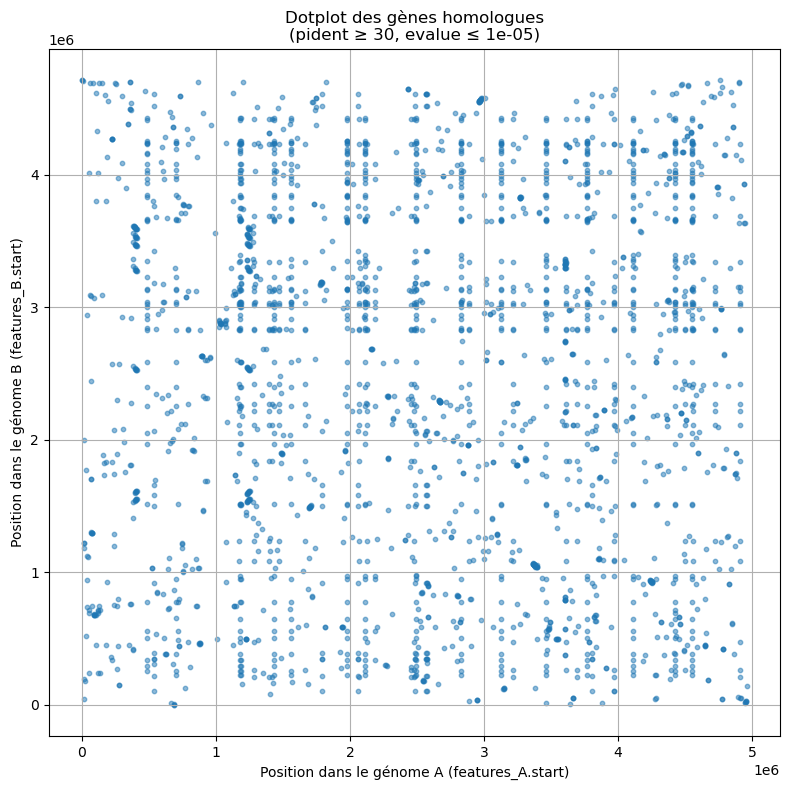

In [25]:
generate_dotplot_from_db_joined("project.db", identity_thresh=30, evalue_thresh=1e-5)

从上面可以看出，其实我们并不能仅仅是通过evalue和identit就可以找到diagonal，所以我在此基础上加了衡量标准，那就是bitscore：

In [47]:
def generate_dotplot_bestmatch(db_path, identity_thresh=30.0, evalue_thresh=1e-5):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # 先筛选 bitscore 最大的匹配（best hit per query）
    cursor.execute("""
    WITH best_match_q AS (
    SELECT qseqid, sseqid, MAX(bitscore) AS bitscore
    FROM blast_hits
    GROUP BY qseqid
    ),
    best_match_s AS (
        SELECT sseqid, qseqid, MAX(bitscore) AS bitscore
        FROM blast_hits
        GROUP BY sseqid
    )
    SELECT bh.qseqid, bh.sseqid, fa.start AS x, fb.start AS y
    FROM blast_hits bh
    JOIN best_match_q bq ON bh.qseqid = bq.qseqid AND bh.sseqid = bq.sseqid AND bh.bitscore = bq.bitscore
    JOIN best_match_s bs ON bh.sseqid = bs.sseqid AND bh.qseqid = bs.qseqid AND bh.bitscore = bs.bitscore
    JOIN features_A fa ON bh.qseqid = fa.protein_id
    JOIN features_B fb ON bh.sseqid = fb.protein_id
    WHERE bh.pident >= ? AND bh.evalue <= ?
    """, (identity_thresh, evalue_thresh))

    points = cursor.fetchall()
    conn.close()

    if not points:
        print("⚠️ 没有找到符合条件的点！")
        return

    x_coords = [pt[2] for pt in points]
    y_coords = [pt[3] for pt in points]

    plt.figure(figsize=(8, 8))
    plt.scatter(x_coords, y_coords, s=10, alpha=0.5)
    plt.title(f"Dotplot des gènes homologues (best match)\n(pident ≥ {identity_thresh}, evalue ≤ {evalue_thresh})")
    plt.xlabel("Position dans le génome A (features_A.start)")
    plt.ylabel("Position dans le génome B (features_B.start)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



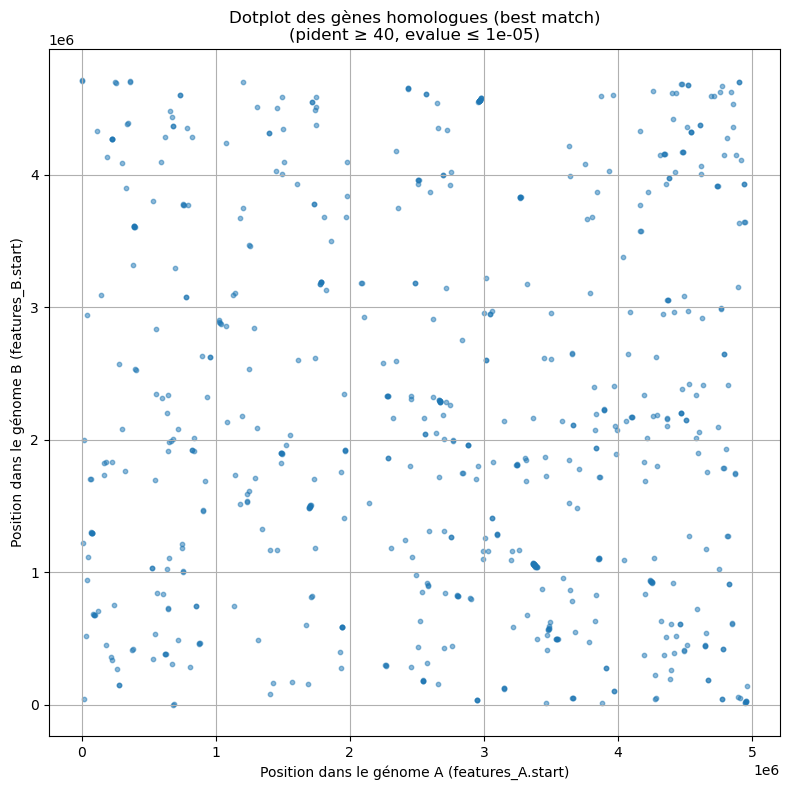

In [49]:
generate_dotplot_bestmatch("project.db", identity_thresh=40, evalue_thresh=1e-5)

Partie-III: 用sql读取.faa文件，提供多余的信息，比如查看序列保守型/GC含量；GUI中也可以显示蛋白序列的详细情况

In [28]:
def parse_faa_file(filepath):
    sequences = {}
    current_id = None
    current_seq = []

    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if current_id and current_seq:
                    sequences[current_id] = "".join(current_seq)
                
                #提取蛋白ID（取第一个空格前）
                current_id = line[1:].split()[0]
                current_seq = []
            else:
                current_seq.append(line)

        #Pour La derniere sequence
        if current_id and current_seq:
            sequences[current_id] = "".join(current_seq)
            
    return sequences

faa和fasta的格式是一样的！读取之后呢我们插入在我们之前建构的这个table中：

In [29]:
def insert_sequences_to_db(conn, table_name, sequences):
    cursor = conn.cursor()
    cursor.execute(f"""
        CREATE TABLE IF NOT EXISTS {table_name}(
            protein_id TEXT PRIMARY KEY,
            sequence TEXT
        )
    """)
    for pid, seq in sequences.items():
        cursor.execute(f"""
            INSERT OR IGNORE INTO {table_name} (protein_id, sequence)
            VALUES (?, ?)
        """, (pid, seq))
    conn.commit()

In [32]:
conn = sqlite3.connect("project.db")
sequences_A = parse_faa_file("GCA_000009985.1_ASM998v1_protein.faa")
insert_sequences_to_db(conn, "sequences_A", sequences_A)
conn.close()

In [33]:
conn = sqlite3.connect("project.db")
sequences_B = parse_faa_file("GCA_000014865.1_ASM1486v1_protein.faa")
insert_sequences_to_db(conn, "sequences_B", sequences_B)
conn.close()